<a href="https://www.kaggle.com/code/brendanedwardcunnie/notebook3df302494a?scriptVersionId=190185669" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from keras.datasets import mnist


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-07-28 17:02:32.339574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 17:02:32.339717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 17:02:32.505090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install keras-utils
import numpy as np
from keras.datasets import mnist
from keras import utils


  Preparing metadata (setup.py) ... - done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=2704afb5d04ccfaef7893e2068f7704037f1ce31417e82609c11f0bcd1372c33
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [3]:
# layer.py
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [4]:
# activation.py
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [5]:
# activations.py
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [6]:
# dense.py

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [7]:
# losses.py

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [8]:
# network.py

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [9]:
# xor.py

# X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
# Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

# network = [
#     Dense(2, 3),
#     Tanh(),
#     Dense(3, 1),
#     Tanh()
# ]

# # train
# train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)

# # decision boundary plot
# points = []
# for x in np.linspace(0, 1, 20):
#     for y in np.linspace(0, 1, 20):
#         z = predict(network, [[x], [y]])
#         points.append([x, y, z[0,0]])

# points = np.array(points)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
# plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


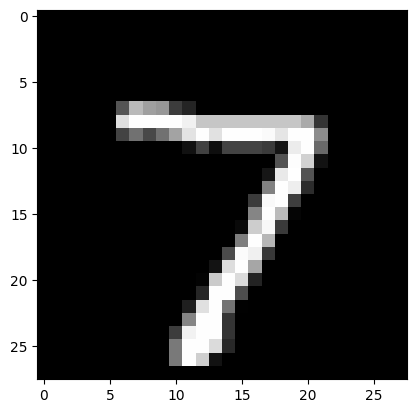

In [10]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


# load MNIST from server
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train, y_train = preprocess_data(x_train0, y_train0, 1000)
x_test, y_test = preprocess_data(x_test0, y_test0, 20)

plt.imshow(x_test0[0], cmap=plt.cm.gray)


In [11]:
# neural network
network = [
    Dense(28 * 28, 40),
    Tanh(),
    Dense(40, 10),
    Tanh()
]

# train
train(network, mse, mse_prime, x_train, y_train, epochs=100, learning_rate=0.1)

1/100, error=0.8792048795986895
2/100, error=0.804911954205214
3/100, error=0.7456700049432539
4/100, error=0.6875947852195139
5/100, error=0.6259385871597792
6/100, error=0.5411578379791531
7/100, error=0.42595654762133395
8/100, error=0.2994398590337631
9/100, error=0.18474144005610896
10/100, error=0.130354987443724
11/100, error=0.11568439991391356
12/100, error=0.10825031304745092
13/100, error=0.10399263295044009
14/100, error=0.10140735429291275
15/100, error=0.09955293207303188
16/100, error=0.09738354921249173
17/100, error=0.09558984771897101
18/100, error=0.09383119073465414
19/100, error=0.09275440259299961
20/100, error=0.09166686092153178
21/100, error=0.09060323440663492
22/100, error=0.08961215103969808
23/100, error=0.08863783806272624
24/100, error=0.08754682282480668
25/100, error=0.08653248145317742
26/100, error=0.08572384403429896
27/100, error=0.08496723390700109
28/100, error=0.08414554158734962
29/100, error=0.08317711135494167
30/100, error=0.08232263584478192

pred: 7 	true: 7
pred: 8 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 0 	true: 5
pred: 7 	true: 9
pred: 0 	true: 0
pred: 4 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 7 	true: 5
pred: 4 	true: 9
pred: 7 	true: 7
pred: 5 	true: 3
pred: 4 	true: 4


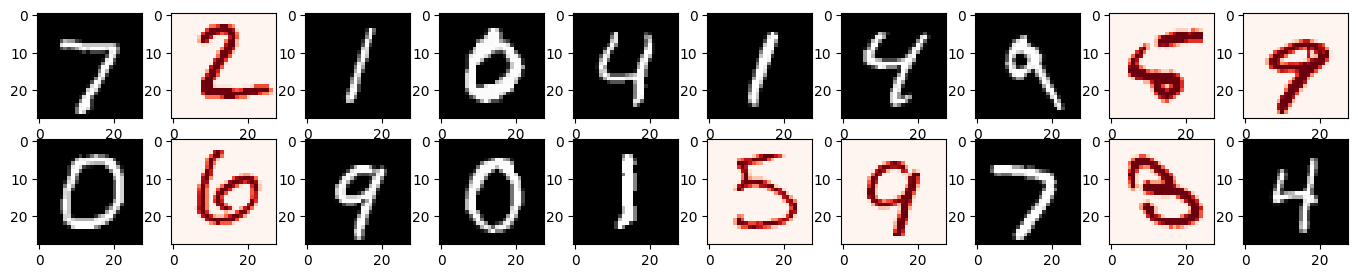

In [12]:
# test
plt.figure(figsize=(17,3))
index = 0

for x0, x, y in zip(x_test0[:20], x_test, y_test):
    output = predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))
    color = plt.cm.gray if np.argmax(output) == np.argmax(y) else plt.cm.Reds
    plt.subplot(2, 10, index+1)
    plt.imshow(x_test0[index], cmap=color)
    index += 1

In [13]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

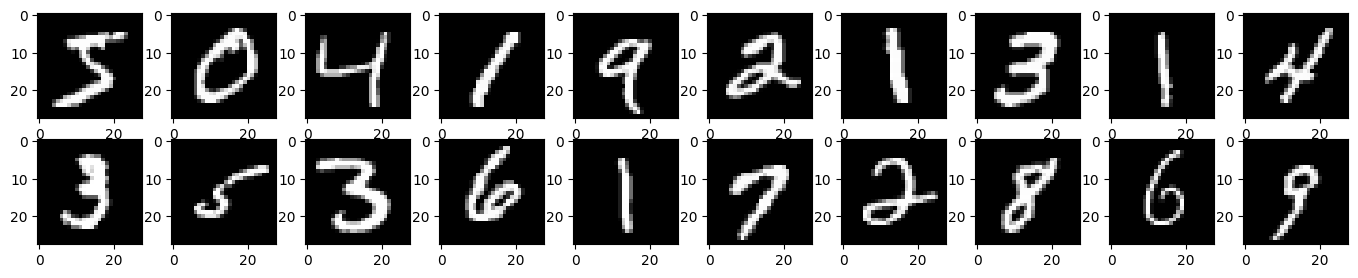

In [14]:
plt.figure(figsize=(17,3))
index = 0
for row in range(2):
    for col in range(10):
        plt.subplot(2, 10, index+1) 
        plt.imshow(x_train0[index], cmap=plt.cm.gray)
        index += 1